<a href="https://colab.research.google.com/github/bh8648/DL/blob/main/DL221031.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

torch.Size([569, 30]) torch.Size([569, 1])
Train 341 / Valid 113 / Test 115 samples.
torch.Size([341, 30]) torch.Size([341, 1])
torch.Size([113, 30]) torch.Size([113, 1])
torch.Size([115, 30]) torch.Size([115, 1])
Epoch 10: train loss=3.2199e-01 / valid_loss=2.5386e-01 / lowest_loss=2.9795e-01
Epoch 20: train loss=5.2722e-02 / valid_loss=9.2020e-02 / lowest_loss=9.2363e-02
Epoch 30: train loss=3.7891e-02 / valid_loss=9.9528e-02 / lowest_loss=9.0985e-02
Epoch 40: train loss=2.5555e-02 / valid_loss=1.1329e-01 / lowest_loss=9.0985e-02
Epoch 50: train loss=1.4399e-02 / valid_loss=1.0932e-01 / lowest_loss=9.0985e-02
Epoch 60: train loss=8.6734e-03 / valid_loss=9.8405e-02 / lowest_loss=9.0985e-02
Epoch 70: train loss=2.4091e-03 / valid_loss=1.2141e-01 / lowest_loss=9.0985e-02
Epoch 80: train loss=1.3338e-03 / valid_loss=1.4172e-01 / lowest_loss=9.0985e-02
Epoch 90: train loss=8.3268e-04 / valid_loss=1.5651e-01 / lowest_loss=9.0985e-02
Epoch 100: train loss=5.6765e-04 / valid_loss=8.2247e-01 

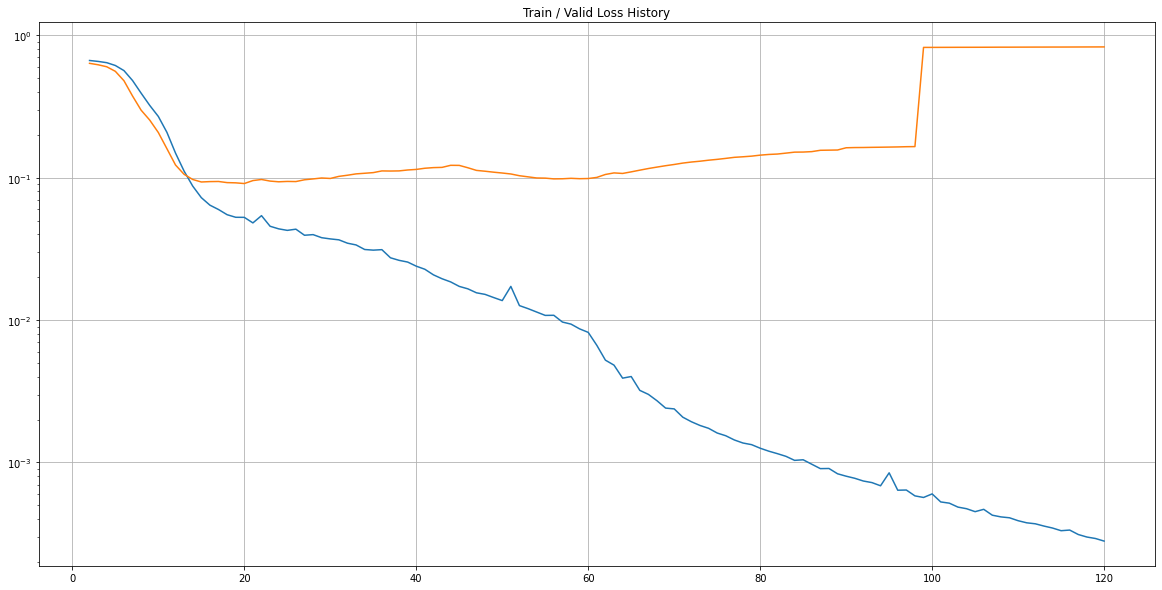

Train loss : 5.2663e-02
Valid loss : 9.0985e-02
Test loss : 5.8465e-02
Test Accuracy: 0.9739


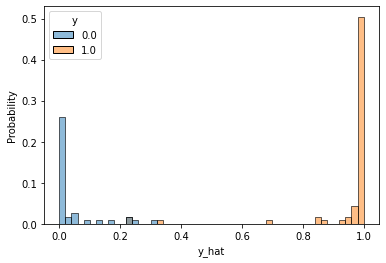

0.9980430528375734

In [16]:
# 크로스엔트로피가 mse보다 이진분류문제에 있어서 더 나은 이유는?


# 모델예측의 결과값은 임계값에따라 구분되어짐

# TP = True Positive


# 데이터셋의 클래스가 불균향하다 -> 실제 정답이 0이나 1 한쪽으로 몰려있다.
# -> 왜 그럴까? 몰려있는 쪽의 결과를 가지는 데이터의 특성은 확인이 되는데 반대쪽의 데이터 특성은 확인이 어렵기 때문아닌가


# 정밀도와 재현율은 서로 반비례관계
# 왜 그럴까? -> FP와 FN의 관계가 반비례 -> 임계값을 오른쪽으로 이동 시 FP감소 FN증가, 왼쪽으로 이동시 FP증가, FN감소


# 1종오류와 2종오류 역시 반비례관계. -> 1종오류와 2종오류란?


# 궁금증2. 수식의 의미는?
# -> 정밀도와 재현율은 반비례이므로 분모는 어차피 같음.
# -> x+y = 1        0 <= x,y <= 1
# -> xy = x(1-x) = -x²+x
# -> -(x² - x + 1/4 - 1/4)
# -> -(x-1/2)²+1/4
# 두 숫자의 사이에 있는 값중 중간에 있는 값을 제곱할 떄가 가장 큼



# ROC 곡선의 x좌표 : 1이라고 모델이 판단한 것의 총합을 실제정답은 0인 것들의 총합으로 나눈 것
# ROC 곡선의 y좌표 : 재현율

# 궁금증3.
# -> 


# ROC곡선이 파란색 점선과 같다면?
# ROC곡선의 x좌표와 y좌표의 값이 같다는 것. -> 모델 출력값의 분포에서 1과 0이 대부분 곂친다는 것.
# 사실상 1/2로 찍기와 다름 없다는 뜻.


# ROC 곡선의 포인트는 임계치 값이 바뀔 때마다 변화하는 그래프라는 것.



# 이진분류 심층신경망 구현

# 필요한 라이브러리 불러오기
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_breast_cancer

# Breast cancer 데이터셋 불러오기
cancer = load_breast_cancer()
df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
df['class'] = cancer.target

# 학습에 필요한 라이브러리 불러오기
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#입출력 데이터 구성
data = torch.from_numpy(df.values).float()
x = data[:, :-1]
y = data[:, -1:]
print(x.shape, y.shape)

#학습, 검증, 평가 데이터셋 비율 설정
ratios = [.6, .2, .2] # Train / Valid / Test ratio

train_cnt = int(data.size(0)*ratios[0])
valid_cnt = int(data.size(0)*ratios[1])
test_cnt = data.size(0) - train_cnt - valid_cnt
cnts = [train_cnt, valid_cnt, test_cnt]

print("Train %d / Valid %d / Test %d samples." % (train_cnt, valid_cnt, test_cnt))

# 데이터셋 샘플을 무작위로 섞고 나누기.

indices = torch.randperm(data.size(0))

x = torch.index_select(x, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)

x = x.split(cnts, dim=0)
y = y.split(cnts, dim=0)

for x_i, y_i in zip(x, y) :
    print(x_i.size(), y_i.size())

# 데이터 정규화
scaler = StandardScaler()
scaler.fit(x[0].numpy())

x = [torch.from_numpy(scaler.transform(x[0].numpy())).float(),
     torch.from_numpy(scaler.transform(x[1].numpy())).float(),
     torch.from_numpy(scaler.transform(x[2].numpy())).float()]

# 심층신경망 모델 구성 및 옵티마이저 설정
model = nn.Sequential(
    nn.Linear(x[0].size(-1), 25),
    nn.LeakyReLU(),
    nn.Linear(25, 20),
    nn.LeakyReLU(),
    nn.Linear(20, 15),
    nn.LeakyReLU(),
    nn.Linear(15, 10),
    nn.LeakyReLU(),
    nn.Linear(10, 5),
    nn.LeakyReLU(),
    nn.Linear(5, y[0].size(-1)),
    nn.Sigmoid()
    )

optimizer = optim.Adam(model.parameters())

# 하이퍼파라미터(hyper-parameter) 설정
n_epochs = 10000
batch_size = 32
print_interval = 10
early_stop = 100
lowest_loss = np.inf
best_model = None
lowest_epoch = np.inf

# 학습/검증 시작

train_history, valid_history = [],[]

for i in range(n_epochs) :
  indices = torch.randperm(x[0].size(0))
  x_ = torch.index_select(x[0], dim=0, index=indices)
  y_ = torch.index_select(y[0], dim=0, index=indices)

  x_ = x_.split(batch_size, dim=0)
  y_ = y_.split(batch_size, dim=0)

  train_loss, valid_loss = 0, 0
  y_hat = []

  for x_i, y_i in zip(x_, y_) :
      y_hat_i = model(x_i)
      loss = F.binary_cross_entropy(y_hat_i, y_i)
        
      optimizer.zero_grad()
      loss.backward()
        
      optimizer.step()
      train_loss += float(loss)
    
  train_loss = train_loss / len(x_)
    
  with torch.no_grad() :
    x_ = x[1].split(batch_size, dim=0)
    y_ = y[1].split(batch_size, dim=0)
    
    valid_loss = 0
    
    for x_i, y_i in zip(x_, y_) :
      y_hat_i = model(x_i)
      loss = F.binary_cross_entropy(y_hat_i, y_i)
      
      valid_loss += float(loss)
      
      y_hat += [y_hat_i]

  valid_loss = valid_loss / len(x_)

  train_history += [train_loss]
  valid_history += [valid_loss]

  if (i+1) % print_interval == 0 :
    print('Epoch %d: train loss=%.4e / valid_loss=%.4e / lowest_loss=%.4e' % (i+1, train_loss, valid_loss, lowest_loss))

  if valid_loss <= lowest_loss :
    lowest_loss = valid_loss
    lowest_epoch = i
    best_model = deepcopy(model.state_dict())

  else :
    if early_stop > 0 and lowest_epoch + early_stop < i+1 :
      print("There is no improvement during last %d epochs." % early_stop)
      break

print("The best validation loss from epoch %d: %.4e" % (lowest_epoch+1, lowest_loss))
model.load_state_dict(best_model)


# 손실 곡선확인
# overfiting 되어버림
# 적절하게 끊어주니 정확도가 0.9826으로 나옴

plot_from = 2

plt.figure(figsize=(20,10))
plt.grid(True)
plt.title("Train / Valid Loss History")
plt.plot(
    range(plot_from, len(train_history)), train_history[plot_from :],
    range(plot_from, len(valid_history)), valid_history[plot_from :],
)
plt.yscale('log')
plt.show()

# 결과 확인 (평가)
test_loss = 0
y_hat = []

with torch.no_grad() :
  x_ = x[2].split(batch_size, dim=0)
  y_ = y[2].split(batch_size, dim=0)

  for x_i, y_i in zip(x_, y_) :
      y_hat_i = model(x_i)
      loss = F.binary_cross_entropy(y_hat_i, y_i)
      test_loss += loss # Gradient is already detached.

      y_hat += [y_hat_i]

test_loss = test_loss / len(x_)
y_hat = torch.cat(y_hat, dim=0)

sorted_history = sorted(zip(train_history, valid_history), key=lambda x: x[1])
print("Train loss : %.4e" % sorted_history[0][0])
print("Valid loss : %.4e" % sorted_history[0][1])
print("Test loss : %.4e" % test_loss)


# 분류 정확도 확인 : 출력값이 0.5보다 크면 1로 분류한 것으로 간주하고 아니면 0으로 간주.
correct_cnt = (y[2] == (y_hat > .5)).sum()
total_cnt = float(y[2].size(0))
print("Test Accuracy: %.4f" % (correct_cnt / total_cnt))


# 참값과 예측값의 분포 확인
df = pd.DataFrame(torch.cat([y[2], y_hat], dim=1).detach().numpy(), columns=['y','y_hat'])
sns.histplot(df, x='y_hat', hue='y', bins=50, stat='probability')
plt.show()


# AUROC 확인
from sklearn.metrics import roc_auc_score

roc_auc_score(df.values[:, 0], df.values[:, 1])




# 문제2는 df.values[:, 0]과 df.values[:,1]을 이용하여 ROC 곡선을 그려보라는 것.

# 문제3은 계층의 개수를 6개에서 점차 줄여보라는 뜻.
# 입출력 노드의 개수를 적절히 맞추어야 함. -> 계층이 많을수록 노드의 수를 줄이라고 했던거 같은데...

